# Example Queries 

This notebook performs some example exploratory analysis on the Companies House data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import duckdb


In [2]:
con = duckdb.connect(database='../earningsai.db', read_only=True)

In [7]:
m1 = con.execute("SELECT * FROM accounts WHERE name = 'PropertyPlantEquipment' AND company = '00011066' LIMIT 100").fetchdf()

## Clean up the data

There are some duplicate entries in this database, owing to the fact that companies typically report their accounts for the previous year as well as the current year. We will remove these duplicates, keeping only the most recent entry for each company and metric.


,schema,name,value,unit,instant,startdate,enddate,company,filing_date
0,http://xbrl.frc.org.uk/fr/2021-01-01/core,PropertyPlantEquipment,50.0,iso4217:GBP,2022-07-31,None,None,00011066,2022-07-31 00:00:00.000000
1,http://xbrl.frc.org.uk/fr/2021-01-01/core,PropertyPlantEquipment,50.0,iso4217:GBP,2021-07-31,None,None,00011066,2022-07-31 00:00:00.000000
2,http://xbrl.frc.org.uk/fr/2021-01-01/core,PropertyPlantEquipment,50.0,iso4217:GBP,2022-07-31,None,None,00011066,2022-07-31 00:00:00.000000
3,http://xbrl.frc.org.uk/fr/2021-01-01/core,PropertyPlantEquipment,50.0,iso4217:GBP,2021-07-31,None,None,00011066,2022-07-31 00:00:00.000000
4,http://xbrl.frc.org.uk/fr/2021-01-01/core,PropertyPlantEquipment,50.0,iso4217:GBP,2021-07-31,None,None,00011066,2021-07-31
5,http://xbrl.frc.org.uk/fr/2021-01-01/core,PropertyPlantEquipment,50.0,iso4217:GBP,2020-07-31,None,None,00011066,2021-07-31
6,http://xbrl.frc.org.uk/fr/2021-01-01/core,PropertyPlantEquipment,50.0,iso4217:GBP,2021-07-31,None,None,00011066,2021-07-31
7,http://xbrl.frc.org.uk/fr/2021-01-01/core,PropertyPlantEquipment,50.0,iso4217:GBP,2020-07-31,None,None,00011066,2021-07-31


In [4]:
con_str = "duckdb://../earningsai.db"

In [5]:
metrics = con.execute("SELECT DISTINCT name FROM accounts ORDER BY name").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [10]:
metrics[metrics["name"].str.contains('Capital')]

,name
226,AverageCapitalEmployed
289,BorrowingCostsCapitalised
299,CalledUpShareCapital
300,CalledUpShareCapitalNot-paidCurrentAsset
301,CalledUpShareCapitalNot-paidCurrentAssetDueWit...
...,...
3032,TotalIssuedClassCapitalAssociate
3033,TotalIssuedClassCapitalJoint-venture
3034,TotalIssuedClassCapitalSubsidiary
3102,TransferToFromProfitLossAccountReserveFromToCa...


In [12]:
metrics['name'].to_csv('metrics.csv', index=False)

## Example 1: Calculate the share of gross capital formation relative to dividend payments

The aim here is to see how much of a company's revenue is being invested back into the company, relative to the amount of dividends paid out to shareholders. This is a simple example of how we can use the data to calculate a ratio that is not directly available in the data.

We will use the following metrics to calculate the dividend payments:
- 'DividendsPaid'
- 'DividendPerShare' 

And to calculate the gross capital formation:
- TotalInventories
- TotalAssetsLessCurrentLiabilities
- Land Improvements
- Construction
- PropertyPlantEquipment
- Intellectual Property
- CapitalEmployed


In [73]:
dividends = con.execute("""SELECT name, count(distinct company) as num_companies, filing_date::date as filing_date, sum(value) as value, unit FROM accounts WHERE name in ('DividendsPaid', 'DividendPerShare') GROUP BY name, filing_date, unit""").fetchdf()

In [72]:
capital = con.execute("""SELECT 'TotalCapital' as name, count(distinct company) as num_companies, filing_date::date as filing_date, sum(value) as capital_value, unit FROM accounts WHERE name in ('TotalInventories', 'TotalAssetsLessCurrentLiabilities', 'PropertyPlantEquipment') AND filing_date::date = instant::date GROUP BY filing_date, unit, instant, startdate, enddate ORDER BY filing_date, instant, startdate""").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [82]:
total_yearly_dividends = dividends.set_index('filing_date').resample('Y')['value'].sum()

In [83]:
total_yearly_capital = capital.set_index('filing_date').resample('Y')['capital_value'].sum()

In [88]:
merged = pd.concat([total_yearly_dividends, total_yearly_capital], axis=1)
merged['ratio'] = merged['value'] / merged['capital_value']

In [93]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Ratio of DividendsPaid to TotalCapital (%)')

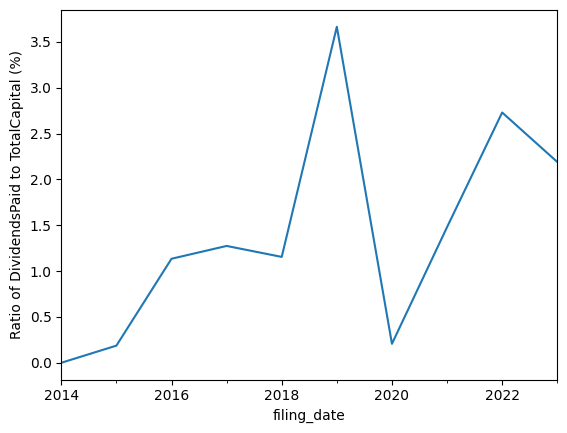

In [94]:
(merged['ratio'] * 100).dropna().plot()
plt.ylabel("Ratio of DividendsPaid to TotalCapital (%)")

In [105]:
remuneration = con.execute("""SELECT name, count(distinct company) as num_companies, filing_date::date as filing_date, sum(value) as value, unit FROM accounts WHERE name in ('DirectorRemuneration','TotalAssets') AND unit = 'iso4217:GBP' GROUP BY name, filing_date, unit""").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [104]:
remuneration

,name,num_companies,filing_date,value,unit
0,TotalAssets,1140,2022-10-31,1.858945e+08,iso4217:GBP
1,TotalAssets,586,2023-01-31,8.403823e+07,iso4217:GBP
2,DirectorRemuneration,636,2022-08-31,1.447415e+08,iso4217:GBP
3,DirectorRemuneration,3545,2022-12-31,1.710782e+09,iso4217:GBP
4,DirectorRemuneration,1166,2022-09-30,3.956984e+08,iso4217:GBP
...,...,...,...,...,...
1723,DirectorRemuneration,1,2017-04-04,3.828540e+05,iso4217:GBP
1724,TotalAssets,1,2019-04-08,1.457490e+05,iso4217:GBP
1725,DirectorRemuneration,1,2023-03-23,3.888000e+04,iso4217:GBP
1726,TotalAssets,1,2019-04-04,2.029400e+05,iso4217:GBP


<Axes: xlabel='filing_date'>

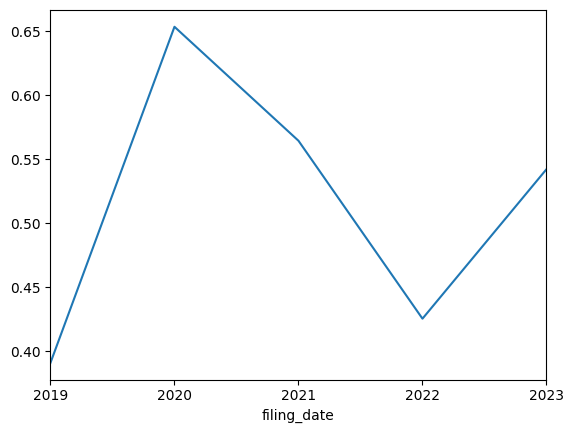

In [116]:
r1 = remuneration.groupby(['filing_date','name'])['value'].sum().unstack()
r1 = r1.resample('Y').sum()
r1['ratio'] = r1['DirectorRemuneration'] / r1['TotalAssets']
r1.loc[r1.index > '2019-01-01']['ratio'].plot()

<Axes: xlabel='filing_date'>

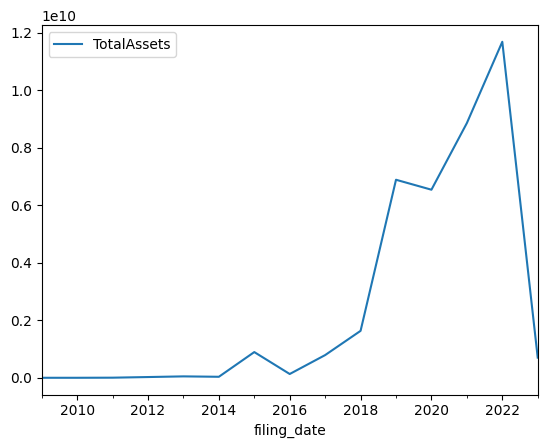

In [117]:
 r1.plot(y='TotalAssets')

## Example 2: Top 10 Companies by ROCE

Return on Capital Employed (ROCE) is a measure of how efficiently a company is using its capital to generate profits. It is calculated as EBIT / Capital Employed.

In [ ]:
ebit = con.execute("""SELECT name, count(distinct company) as num_companies, filing_date::date as filing_date, sum(value) as value, unit FROM accounts WHERE name = 'OperatingProfitLoss' AND unit = 'iso4217:GBP' GROUP BY name, filing_date, unit""").fetchdf()
capital = con.execute("""SELECT name, count(distinct company) as num_companies, filing_date::date as filing_date, sum(value) as value, unit FROM accounts WHERE name = 'NetAssetsLiabilities ' AND unit = 'iso4217:GBP' GROUP BY name, filing_date, unit""").fetchdf()


In [125]:
num_companies = con.execute("""SELECT filing_date::date as filing_date, count(distinct company) as num_companies FROM accounts GROUP BY filing_date order by filing_date""").fetchdf()
num_total_asset_companies = con.execute("""SELECT filing_date::date as filing_date, count(distinct company) as num_asset_companies FROM accounts WHERE name = 'TotalAssets' GROUP BY filing_date order by filing_date""").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<Axes: xlabel='filing_date'>

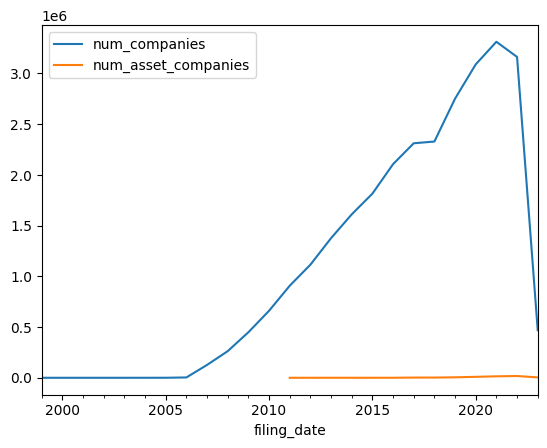

In [127]:
pd.concat([num_companies.set_index('filing_date').resample('Y').sum(),
num_total_asset_companies.set_index('filing_date').resample('Y').sum()], axis=1).plot()

<Axes: xlabel='filing_date'>

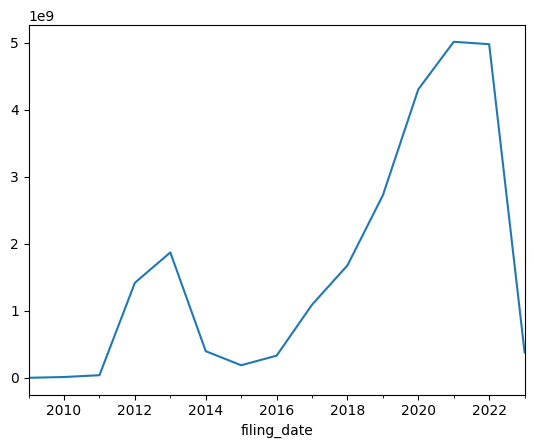

In [100]:
remuneration.set_index('filing_date').resample('Y')['value'].sum().plot()